### Curriculum classifier demo

This notebook documents an exploration of machine learning classifiers with a focus on **predictive accuracy** and **fairness metrics**. The main goals of this analysis are:
- To evaluate the performance of different classifiers using various metrics.
- To examine the trade-offs between accuracy and fairness across models.

#### Dataset
The dataset is the fairlearn adult dataset.

Sensitive Features: **Race** and **Sex**.
Target: **Salary** (<=50K, >50K)

#### Metrics Evaluated
The notebook assesses models using:
- **Accuracy, Recall, and F1 Score** for predictive performance.
- **Fairness Metrics**:
  - **Demographic Parity Difference** and **Ratio**.
  - **Equalized Odds Difference**.
  - **Equal Opportunity Difference**.

#### Models Tested
The following classifiers are analyzed:
1. **Curriculum Classifier (Entropy-Based)**: Emphasizes predictive power but has moderate fairness concerns.
2. **Curriculum Classifier (Average Confidence-Based)**: Prioritizes fairness at the cost of some predictive performance.
3. **Stochastic Gradient Descent (SGD) Classifier**: Provides a balance but performs poorly on fairness and accuracy.

The notebook concludes with recommendations for model selection based on use-case priorities.


In [21]:
from fairlearn.datasets import fetch_adult

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from src.classifiers.curriculum_classifier import CurriculumClassifier

### Import dataset

The following code processes the **Adult Income dataset** from `sklearn.datasets` to prepare it for fairness evaluation:

In [22]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
sensitive_feature_names = ['sex', 'race']

sensitive_features = X[sensitive_feature_names]
X = X.drop(columns=sensitive_feature_names)

X.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

### Replace missing values using the mode

In [23]:
X['workclass'].fillna(X.mode()['workclass'][0], inplace=True)
X['occupation'].fillna(X.mode()['occupation'][0], inplace=True)
X['native-country'].fillna(X.mode()['native-country'][0], inplace=True)

C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_9040\3529112877.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['workclass'].fillna(X.mode()['workclass'][0], inplace=True)
C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_9040\3529112877.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

### Encode categorical features

In [24]:
# Encode categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X = preprocessor.fit_transform(X).toarray()

### Split the dataset into training and test sets

- Random seed is set to 1234 for reproducibility
- The dataset is split into training and test sets using an 80-20 split ratio
- Features, target, and sensitive features are split accordingly
- The `CurriculumClassifier` is instantiated with an SGDClassifier once for each method
- The SGDClassifier is instantiated separately

Target is salary, with the following classes:
- <=50K
- \>50K

In [25]:
random_seed = 1234

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_features, test_size=0.2, random_state=random_seed
)

curriculum_classifier_ent = CurriculumClassifier(base_estimator=SGDClassifier(random_state=random_seed),
                                                 method='entropy', n_groups=3)
curriculum_classifier_ent.fit(X_train, y_train)

curriculum_classifier_acc = CurriculumClassifier(base_estimator=SGDClassifier(random_state=random_seed),
                                                 method='avg_confidence', n_groups=3)
curriculum_classifier_acc.fit(X_train, y_train)

sgd_classifier = SGDClassifier(random_state=random_seed)
sgd_classifier.fit(X_train, y_train)

2025-01-19 21:32:34,186 - curriculum_classifier.py:38 -             __init__() - [DEBUG]: partial_fit present: True
2025-01-19 21:32:34,306 - learning_difficulty.py:48 -  group_by_difficulty() - [DEBUG]: Using entropy to calculate difficulty.
2025-01-19 21:32:34,309 - learning_difficulty.py:57 -  group_by_difficulty() - [DEBUG]: Sorted indices: [   16     1     2 ... 39071 37961 23880] of shape (39073,)
2025-01-19 21:32:34,322 - curriculum_classifier.py:67 -                  fit() - [DEBUG]: Fitting group with 13025 samples
2025-01-19 21:32:34,340 - curriculum_classifier.py:67 -                  fit() - [DEBUG]: Fitting group with 13024 samples
2025-01-19 21:32:34,357 - curriculum_classifier.py:67 -                  fit() - [DEBUG]: Fitting group with 13024 samples
2025-01-19 21:32:34,374 - curriculum_classifier.py:73 -                  fit() - [DEBUG]: Fitting completed
2025-01-19 21:32:34,377 - curriculum_classifier.py:38 -             __init__() - [DEBUG]: partial_fit present: True


SGDClassifier(random_state=1234)

### Make predictions for each classifier

In [26]:
y_pred_curriculum_ent = curriculum_classifier_ent.predict(X_test)
y_pred_curriculum_acc = curriculum_classifier_acc.predict(X_test)
y_pred_sgd = sgd_classifier.predict(X_test)

### Calculate standard metrics for each classifier

In [27]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

y_pred_curriculum_accuracy_ent = accuracy_score(y_test, y_pred_curriculum_ent)
y_pred_curriculum_recall_ent = recall_score(y_test, y_pred_curriculum_ent, average='weighted')
y_pred_curriculum_f1_ent = f1_score(y_test, y_pred_curriculum_ent, average='weighted')

y_pred_curriculum_accuracy_acc = accuracy_score(y_test, y_pred_curriculum_acc)
y_pred_curriculum_recall_acc = recall_score(y_test, y_pred_curriculum_acc, average='weighted')
y_pred_curriculum_f1_acc = f1_score(y_test, y_pred_curriculum_acc, average='weighted')

y_pred_sgd_accuracy = accuracy_score(y_test, y_pred_sgd)
y_pred_sgd_recall = recall_score(y_test, y_pred_sgd, average='weighted')
y_pred_sgd_f1 = f1_score(y_test, y_pred_sgd, average='weighted')

### Plot metrics for each classifier

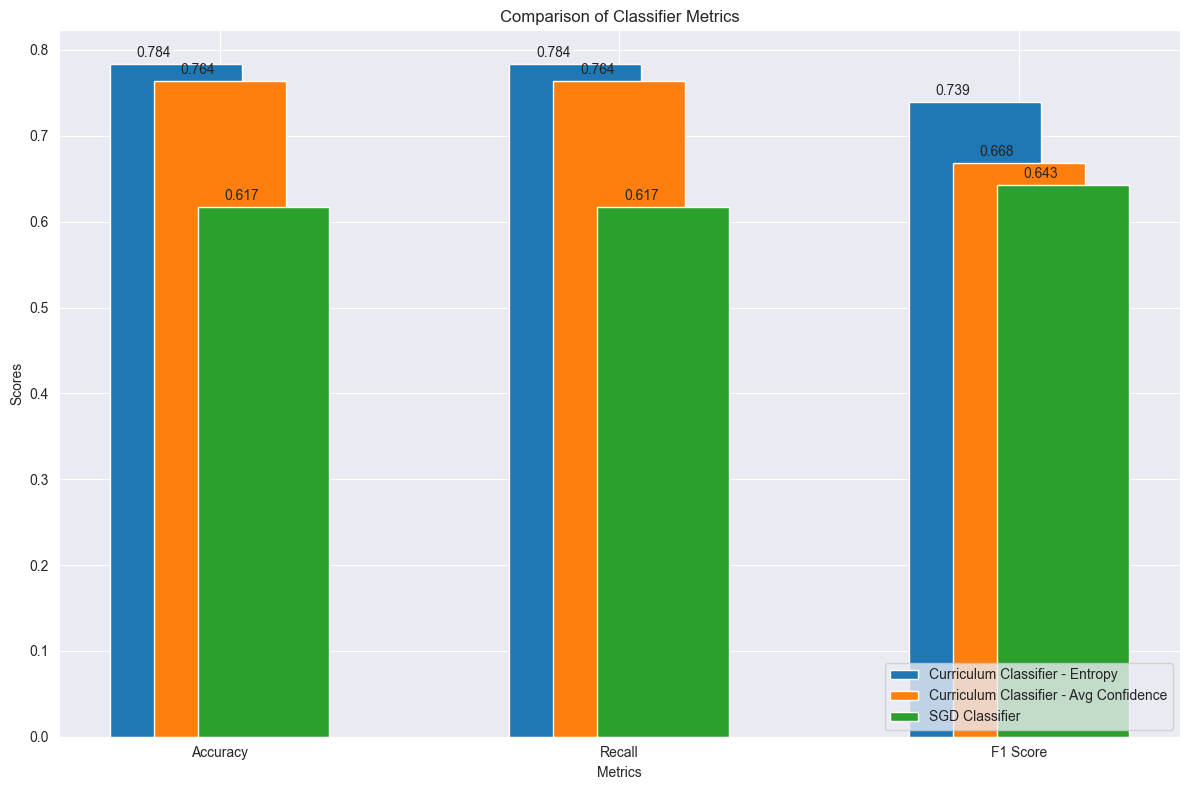

In [28]:
import matplotlib.pyplot as plt
import numpy as np

curriculum_ent_metrics = [
    y_pred_curriculum_accuracy_ent,
    y_pred_curriculum_recall_ent,
    y_pred_curriculum_f1_ent
]

curriculum_acc_metrics = [
    y_pred_curriculum_accuracy_acc,
    y_pred_curriculum_recall_acc,
    y_pred_curriculum_f1_acc
]

sgd_metrics = [
    y_pred_sgd_accuracy,
    y_pred_sgd_recall,
    y_pred_sgd_f1
]

metric_names = ['Accuracy', 'Recall', 'F1 Score']

x = np.arange(len(metric_names))

width = 0.33
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width / 3, curriculum_ent_metrics, width, label='Curriculum Classifier - Entropy')
bars2 = ax.bar(x, curriculum_acc_metrics, width, label='Curriculum Classifier - Avg Confidence')
bars3 = ax.bar(x + width / 3, sgd_metrics, width, label='SGD Classifier')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classifier Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(loc='lower right')


def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(bar.get_x() + bar.get_width() / 3, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

fig.tight_layout()

plt.show()

### Plot confusion matrix

2025-01-19 21:32:38,901 - colorbar.py:872 - _get_ticker_locator_formatter() - [DEBUG]: locator: <matplotlib.ticker.AutoLocator object at 0x0000024B69C8ACC0>
2025-01-19 21:32:38,989 - colorbar.py:872 - _get_ticker_locator_formatter() - [DEBUG]: locator: <matplotlib.ticker.AutoLocator object at 0x0000024B68B36210>
2025-01-19 21:32:39,061 - colorbar.py:872 - _get_ticker_locator_formatter() - [DEBUG]: locator: <matplotlib.ticker.AutoLocator object at 0x0000024B68B37770>


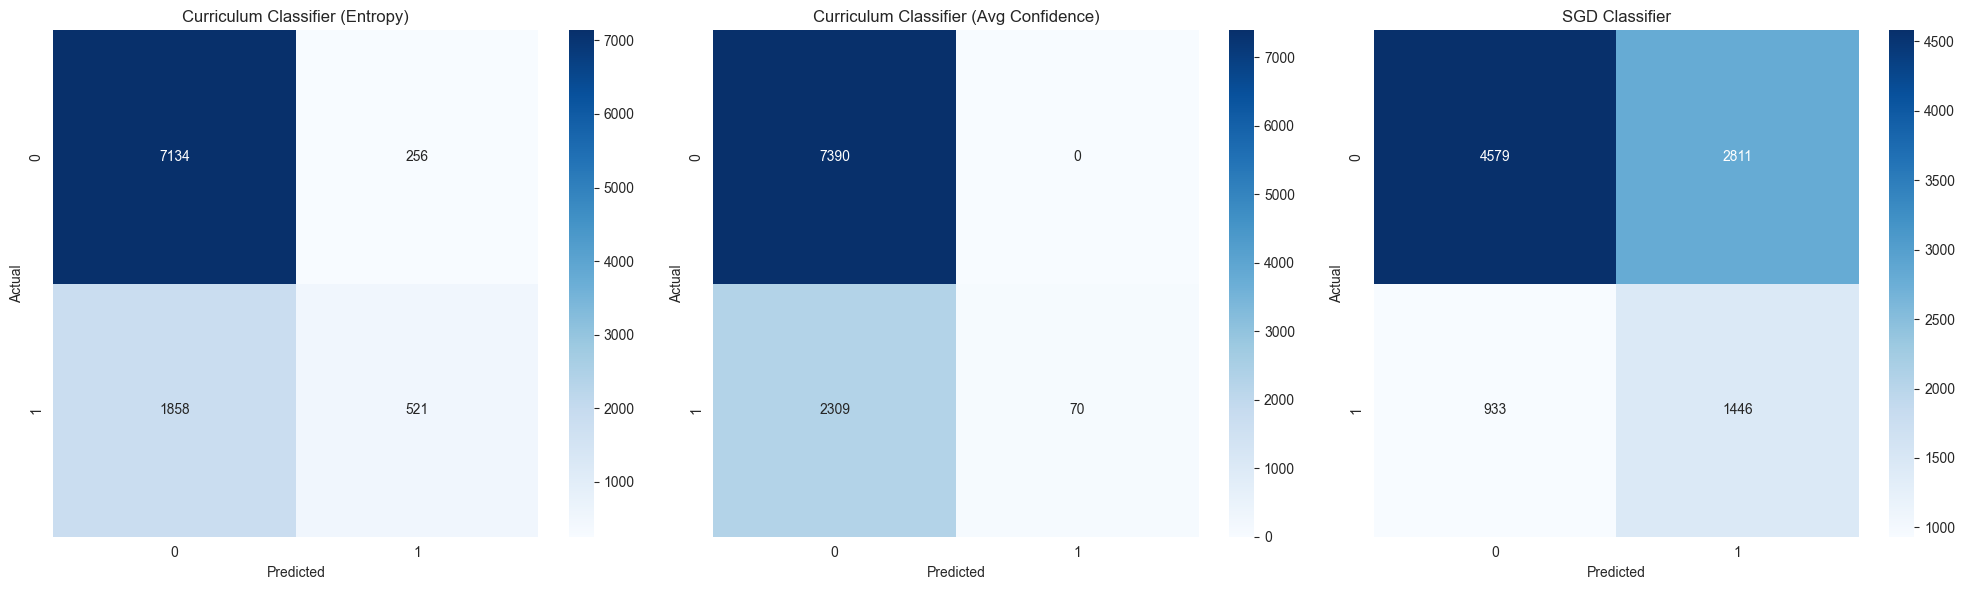

In [29]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

conf_matrix_curriculum_ent = confusion_matrix(y_test, y_pred_curriculum_ent)
conf_matrix_curriculum_acc = confusion_matrix(y_test, y_pred_curriculum_acc)
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)

sns.heatmap(conf_matrix_curriculum_ent, annot=True, fmt='d', cmap='Blues', ax=axes[0])
sns.heatmap(conf_matrix_curriculum_acc, annot=True, fmt='d', cmap='Blues', ax=axes[1])
sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Blues', ax=axes[2])

axes[0].set_title('Curriculum Classifier (Entropy)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

axes[1].set_title('Curriculum Classifier (Avg Confidence)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

axes[2].set_title('SGD Classifier')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()

plt.show()

### Confusion matrices

#### **1. Curriculum Classifier (Entropy)**
- **True Negatives (7134)**: High number of correctly classified negative samples.
- **False Positives (256)**: Few negative samples incorrectly classified as positive.
- **False Negatives (1858)**: A notable number of positive samples misclassified as negative.
- **True Positives (521)**: Low count of correctly classified positive samples.

**Key Observation**:
- This model is highly biased toward predicting the negative class (`0`), resulting in low sensitivity (recall) for the positive class.

---

#### **2. Curriculum Classifier (Average Confidence)**
- **True Negatives (7390)**: High count of correctly classified negative samples.
- **False Positives (0)**: Perfect performance in avoiding false positives (negative samples classified as positive).
- **False Negatives (2309)**: More positive samples misclassified as negative compared to the entropy model.
- **True Positives (70)**: Very few correctly classified positive samples.

**Key Observation**:
- This model sacrifices recall for the positive class to achieve perfect precision, avoiding false positives entirely.

---

#### **3. SGD Classifier**
- **True Negatives (4579)**: Moderate number of correctly classified negative samples.
- **False Positives (2811)**: High count of negative samples misclassified as positive.
- **False Negatives (933)**: Lower number of misclassified positive samples compared to the curriculum classifiers.
- **True Positives (1446)**: The highest count of correctly classified positive samples among the models.

**Key Observation**:
- This model performs better in detecting positive samples but struggles significantly with negative samples, resulting in many false positives.

---

### Key Takeaways

#### **Curriculum Classifier (Entropy)**:
- Balances positive and negative classification but shows a bias toward predicting the negative class.
- Low recall for the positive class.

#### **Curriculum Classifier (Average Confidence)**:
- Focuses on avoiding false positives, achieving perfect precision but at the cost of recall for the positive class.
- Performs poorly in detecting positive samples.

#### **SGD Classifier**:
- Detects positive samples better than the curriculum classifiers, resulting in higher recall.
- Struggles with false positives, leading to lower precision.


### Calculate fairness metrics
Also encode class labels for fairness metrics calculation:

- Demographic Parity Difference (DPD)
- Equalized Odds Difference (EOD)
- Equal Opportunity Difference (EQOD)
- Demographic Parity Ratio (DPR)
- Equal Opportunity Ratio (EOR)

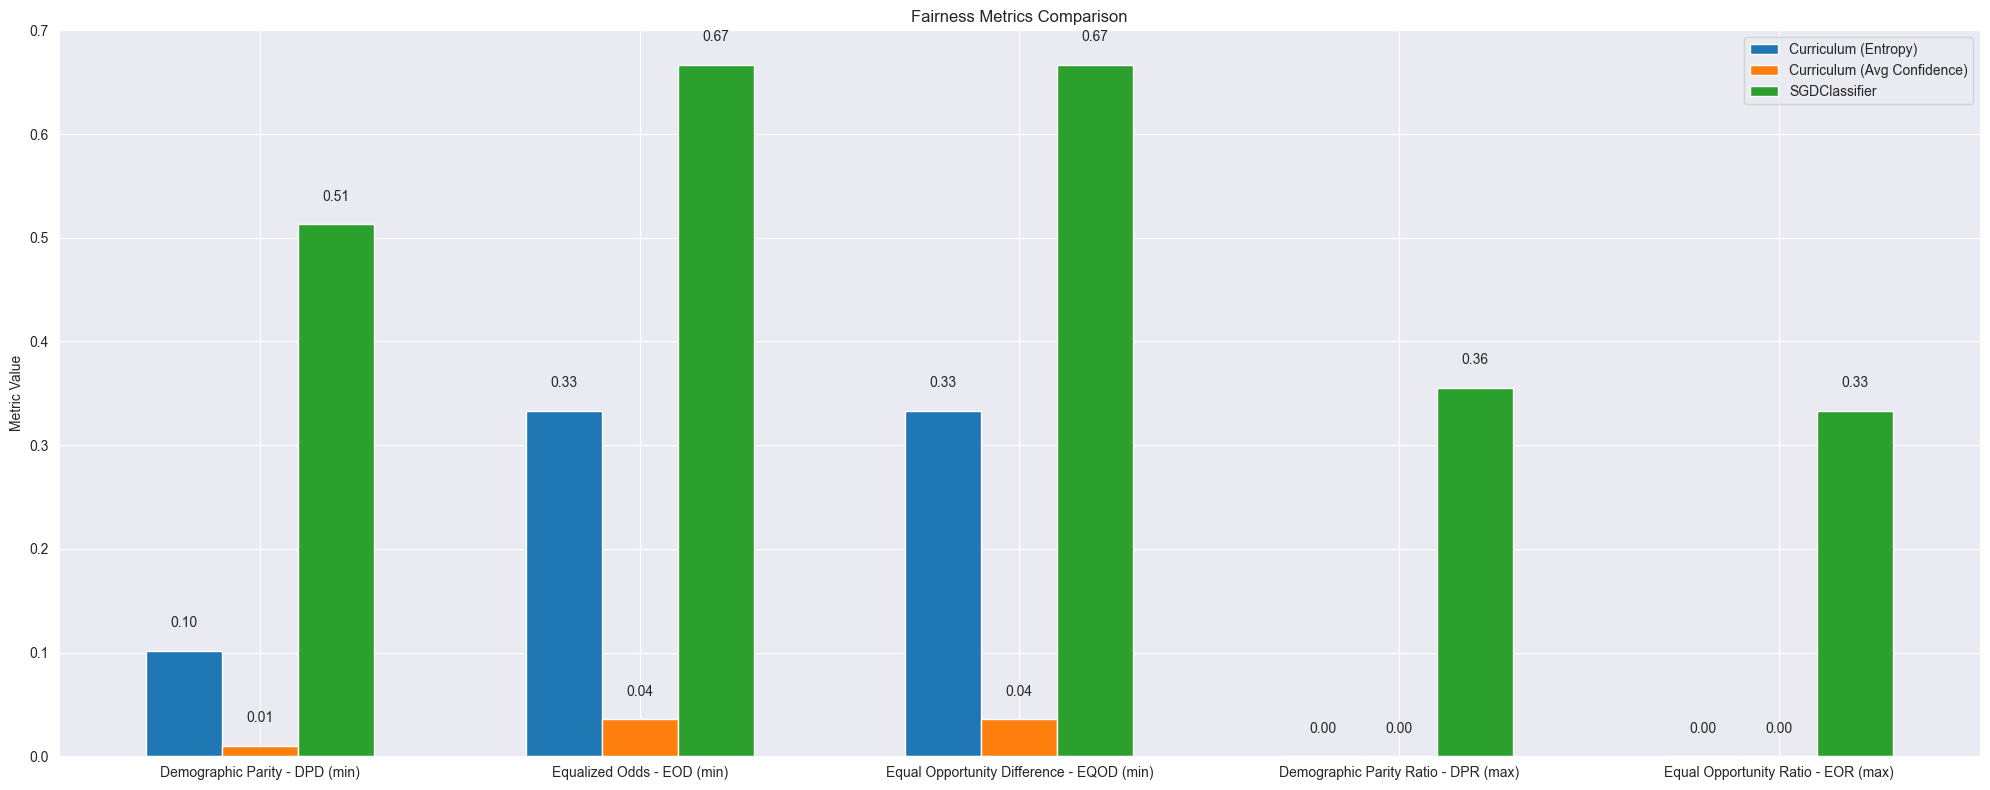

In [30]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, equal_opportunity_difference, \
    demographic_parity_ratio, equal_opportunity_ratio
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_curriculum_ent_encoded = label_encoder.transform(y_pred_curriculum_ent)
y_pred_curriculum_acc_encoded = label_encoder.transform(y_pred_curriculum_acc)
y_pred_sgd_encoded = label_encoder.transform(y_pred_sgd)

# Entropy
dpd_ent = demographic_parity_difference(y_test_encoded, y_pred_curriculum_ent_encoded,
                                        sensitive_features=sensitive_test)
eod_ent = equalized_odds_difference(y_test_encoded, y_pred_curriculum_ent_encoded, sensitive_features=sensitive_test)
eqod_ent = equal_opportunity_difference(y_test_encoded, y_pred_curriculum_ent_encoded,
                                        sensitive_features=sensitive_test)
dpr_ent = demographic_parity_ratio(y_test_encoded, y_pred_curriculum_ent_encoded, sensitive_features=sensitive_test)
eor_ent = equal_opportunity_ratio(y_test_encoded, y_pred_curriculum_ent_encoded, sensitive_features=sensitive_test)

# Avg Confidence
dpd_acc = demographic_parity_difference(y_test_encoded, y_pred_curriculum_acc_encoded,
                                        sensitive_features=sensitive_test)
eod_acc = equalized_odds_difference(y_test_encoded, y_pred_curriculum_acc_encoded, sensitive_features=sensitive_test)
eqod_acc = equal_opportunity_difference(y_test_encoded, y_pred_curriculum_acc_encoded,
                                        sensitive_features=sensitive_test)
dpr_acc = demographic_parity_ratio(y_test_encoded, y_pred_curriculum_acc_encoded, sensitive_features=sensitive_test)
eor_acc = equal_opportunity_ratio(y_test_encoded, y_pred_curriculum_acc_encoded, sensitive_features=sensitive_test)

# SGD
dpd_sgd = demographic_parity_difference(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
eod_sgd = equalized_odds_difference(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
eqod_sgd = equal_opportunity_difference(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
dpr_sgd = demographic_parity_ratio(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)
eor_sgd = equal_opportunity_ratio(y_test_encoded, y_pred_sgd_encoded, sensitive_features=sensitive_test)

values_ent = [dpd_ent, eod_ent, eqod_ent, dpr_ent, eor_ent]
values_acc = [dpd_acc, eod_acc, eqod_acc, dpr_acc, eor_acc]
values_sgd = [dpd_sgd, eod_sgd, eqod_sgd, dpr_sgd, eor_sgd]

labels = ["Demographic Parity - DPD (min)",
          "Equalized Odds - EOD (min)",
          "Equal Opportunity Difference - EQOD (min)",
          "Demographic Parity Ratio - DPR (max)",
          "Equal Opportunity Ratio - EOR (max)"
          ]
x = range(len(labels))

fig, ax = plt.subplots(figsize=(20, 8))

ax.bar([i - 0.2 for i in x], [dpd_ent, eod_ent, eqod_ent, dpr_ent, eor_ent], width=0.2, label="Curriculum (Entropy)")
ax.bar(x, [dpd_acc, eod_acc, eqod_acc, dpr_acc, eor_acc], width=0.2, label="Curriculum (Avg Confidence)")
ax.bar([i + 0.2 for i in x], [dpd_sgd, eod_sgd, eqod_sgd, dpr_sgd, eor_sgd], width=0.2, label="SGDClassifier")

for i, value in enumerate(values_ent):
    ax.text(i - 0.2, value + 0.02, f"{value:.2f}", ha='center', va='bottom')
for i, value in enumerate(values_acc):
    ax.text(i, value + 0.02, f"{value:.2f}", ha='center', va='bottom')
for i, value in enumerate(values_sgd):
    ax.text(i + 0.2, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title("Fairness Metrics Comparison")
ax.set_ylabel("Metric Value")
ax.legend()

plt.tight_layout()
plt.show()


### Results

#### 1. Curriculum Classifier (Entropy)
- **Strengths**:
  - **Accuracy (78.4%)** and **Recall (78.4%)** are the highest among the three classifiers, balancing predictive power with a good ability to correctly identify positive outcomes.
  - **F1 Score (73.9%)** is the highest, indicating strong precision and recall performance.

- **Weaknesses**:
  - **Fairness metrics show moderate issues**:
    - **Demographic Parity Difference (0.102)** and **Equalized Odds Difference (0.333)** indicate disparities in selection rates and predictive performance across sensitive groups.
    - **Demographic Parity Ratio (0.0)** and **Equal Opportunity Ratio (0.0)** are problematic, showing a complete lack of selection or opportunity for the least favored group.
  - This classifier prioritizes **predictive power but sacrifices fairness**.

---

#### 2. Curriculum Classifier (Average Confidence)
- **Strengths**:
  - **Fairness metrics are excellent**:
    - **Demographic Parity Difference (0.010)** and **Equalized Odds Difference (0.036)** are very low, indicating near-perfect fairness in selection rates and predictive performance.
    - **Equal Opportunity Difference (0.036)** is also very low, showing equitable benefits across groups.
  - **Improved fairness metrics make this classifier the most equitable**.

- **Weaknesses**:
  - **Accuracy (76.4%)**, **Recall (76.4%)**, and **F1 Score (66.8%)** are lower than the entropy-based classifier.
  - Sacrifices some predictive performance to achieve better fairness.

---

#### 3. SGD Classifier
- **Strengths**:
  - **F1 Score (64.3%)** is comparable to the curriculum classifier (average confidence), showing a reasonable balance between precision and recall.

- **Weaknesses**:
  - **Poor fairness metrics**:
    - **Demographic Parity Difference (0.513)** and **Equalized Odds Difference (0.667)** are very high, indicating significant disparities in selection and predictive performance.
    - **Demographic Parity Ratio (0.355)** and **Equal Opportunity Ratio (0.333)** are far from ideal, suggesting inequitable treatment of groups.
  - **Accuracy (61.7%)** and **Recall (61.7%)** are the lowest, showing poor predictive performance.
  - This classifier **fails on both fairness and accuracy**, making it the least desirable option.

---

### Summary
- **Best for Accuracy and Predictive Power**: Curriculum Classifier (Entropy)
  - Use when predictive performance is the top priority, with moderate fairness concerns.
- **Best for Fairness**: Curriculum Classifier (Average Confidence)
  - Ideal when equity across sensitive groups is the primary objective.
- **Avoid Using**: SGD Classifier
  - Performs poorly on both fairness and predictive power.


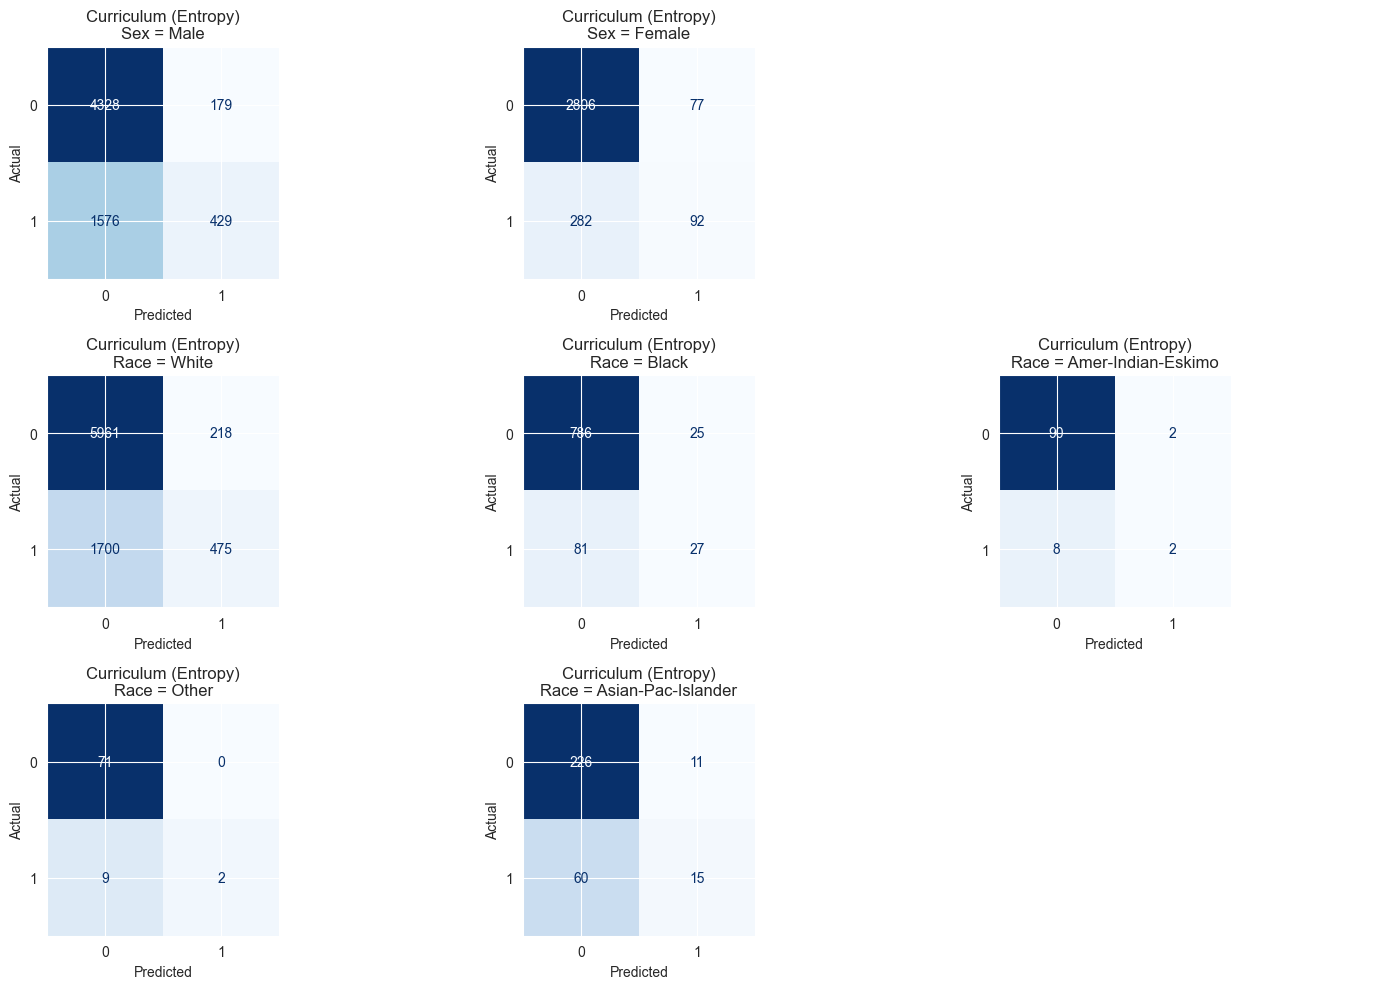

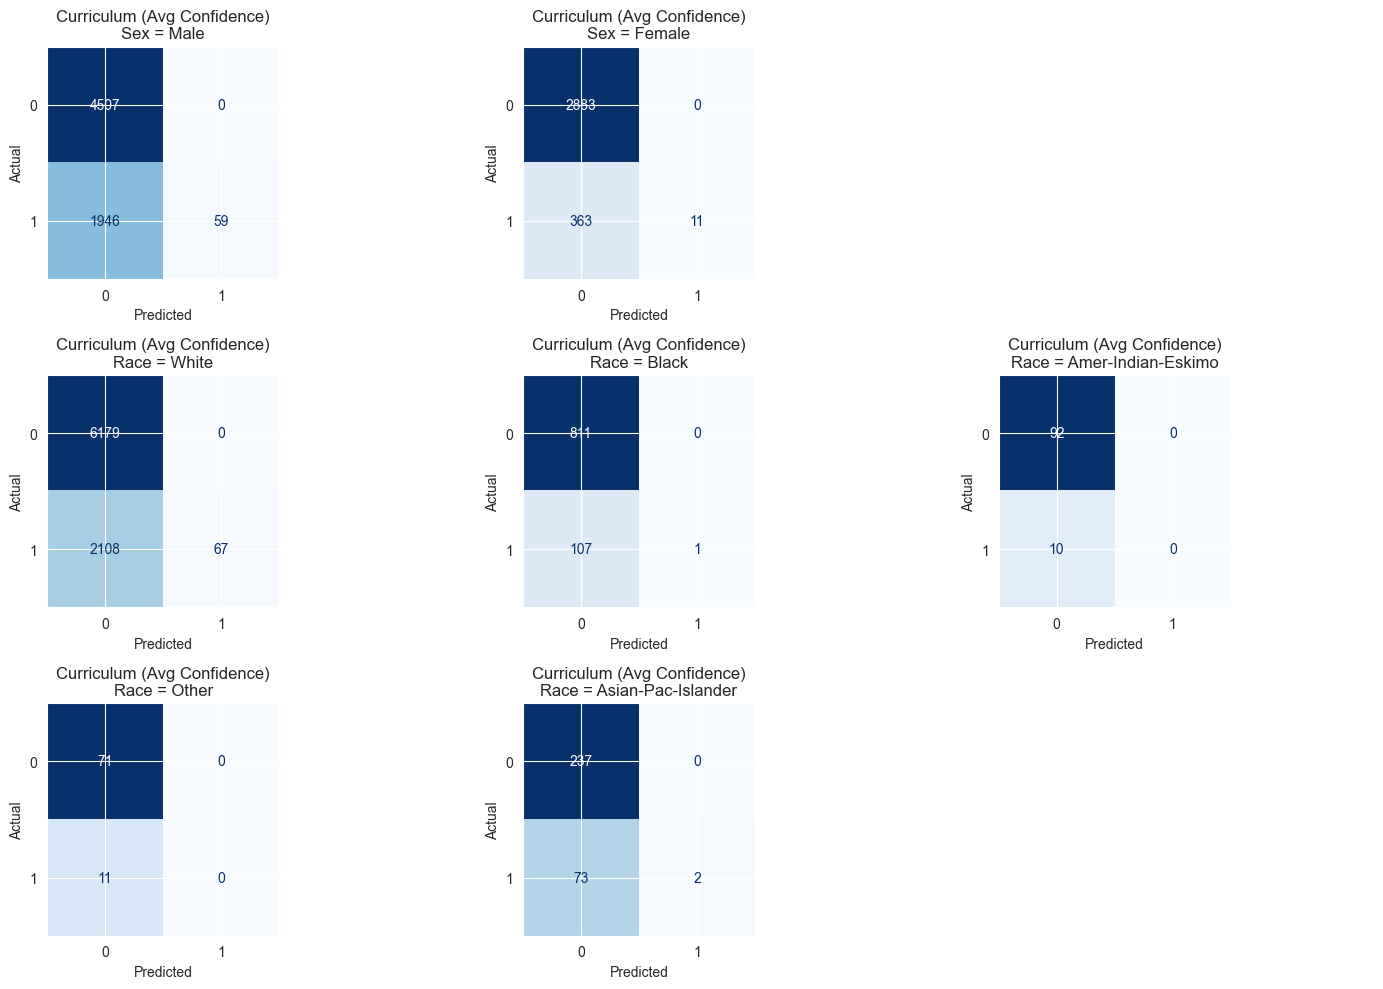

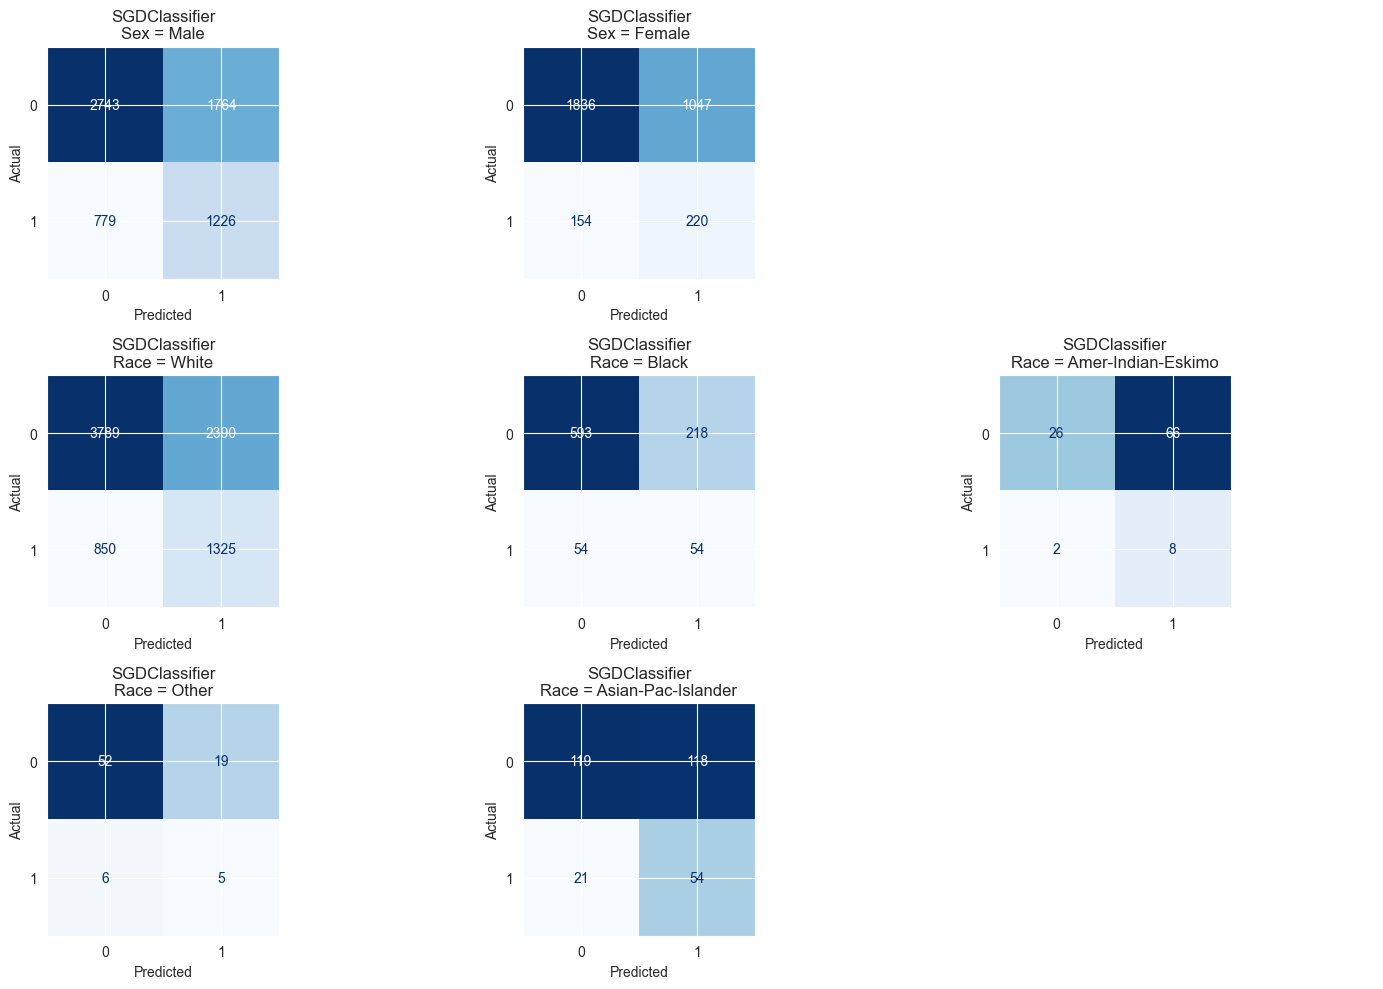

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sensitive_features = {"sex": sensitive_test['sex'], "race": sensitive_test['race']}
sensitive_group_values = {key: feature.unique() for key, feature in sensitive_features.items()}

model_predictions = {
    "Curriculum (Entropy)": y_pred_curriculum_ent_encoded,
    "Curriculum (Avg Confidence)": y_pred_curriculum_acc_encoded,
    "SGDClassifier": y_pred_sgd_encoded,
}

n_cols_per_row = 3

for model_name, y_pred in model_predictions.items():
    fig, axes = plt.subplots(
        sum((len(values) + n_cols_per_row - 1) // n_cols_per_row for values in sensitive_group_values.values()),
        n_cols_per_row,
        figsize=(5 * n_cols_per_row, 5 * len(sensitive_features)),
        squeeze=False
    )

    row_index = 0

    for feature_name, feature_values in sensitive_group_values.items():
        for i, group in enumerate(feature_values):
            mask = (sensitive_features[feature_name] == group)
            y_true_group = y_test_encoded[mask]
            y_pred_group = y_pred[mask]

            cm = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1])

            col_index = i % n_cols_per_row
            if i > 0 and i % n_cols_per_row == 0:
                row_index += 1

            ax = axes[row_index, col_index]
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
            disp.plot(ax=ax, cmap="Blues", colorbar=False)
            ax.set_title(f"{model_name}\n{feature_name.capitalize()} = {group}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")

        for col_index in range(len(feature_values) % n_cols_per_row, n_cols_per_row):
            axes[row_index, col_index].axis('off')

        row_index += 1

    plt.tight_layout()
    plt.show()


### Explanation of Confusion Matrices for All Models by Sensitive Feature Values

The confusion matrices displayed above show the classification performance of three models: **Curriculum Classifier (Entropy)**, **Curriculum Classifier (Avg Confidence)**, and **SGDClassifier**, segmented by values of the sensitive features **`sex`** and **`race`**. Each matrix captures the distribution of predictions for the positive class (`1`) and negative class (`0`) within each subgroup.

---

## **Curriculum Classifier (Entropy)**

#### **Confusion Matrices for `sex`**
- **Sex = Male**:
  - **True Negatives (4328)**: Correctly classified as negative.
  - **False Positives (179)**: Misclassified as positive when they are actually negative.
  - **False Negatives (1576)**: Misclassified as negative when they are actually positive.
  - **True Positives (429)**: Correctly classified as positive.
  - **Observation**:
    - The model struggles with identifying positive samples (low recall), evident from the high number of false negatives.

- **Sex = Female**:
  - **True Negatives (2806)**: Correctly classified as negative.
  - **False Positives (77)**: Misclassified as positive when they are actually negative.
  - **False Negatives (282)**: Misclassified as negative when they are actually positive.
  - **True Positives (92)**: Correctly classified as positive.
  - **Observation**:
    - Better performance compared to males, with significantly fewer false negatives, resulting in better recall.

#### **Confusion Matrices for `race`**
- **Race = White**:
  - **True Negatives (5061)**: Correctly classified as negative.
  - **False Positives (218)**: Misclassified as positive.
  - **False Negatives (1700)**: Misclassified as negative.
  - **True Positives (475)**: Correctly classified as positive.
  - **Observation**:
    - High false negatives for this group, indicating poor recall.

- **Race = Black**:
  - **True Negatives (736)**: Correctly classified as negative.
  - **False Positives (25)**: Misclassified as positive.
  - **False Negatives (81)**: Misclassified as negative.
  - **True Positives (27)**: Correctly classified as positive.
  - **Observation**:
    - Better precision than other groups, with fewer false positives.

- **Race = Amer-Indian-Eskimo**:
  - **True Negatives (9)**: Correctly classified as negative.
  - **False Positives (2)**: Misclassified as positive.
  - **False Negatives (8)**: Misclassified as negative.
  - **True Positives (2)**: Correctly classified as positive.
  - **Observation**:
    - Small sample size makes the results less reliable.

- **Race = Asian-Pac-Islander**:
  - **True Negatives (236)**: Correctly classified as negative.
  - **False Positives (11)**: Misclassified as positive.
  - **False Negatives (60)**: Misclassified as negative.
  - **True Positives (15)**: Correctly classified as positive.
  - **Observation**:
    - Decent performance, though recall remains an issue.

---

## **Curriculum Classifier (Avg Confidence)**

#### **Confusion Matrices for `sex`**
- **Sex = Male**:
  - **True Negatives (4587)**: Correctly classified as negative.
  - **False Positives (0)**: No negative samples misclassified as positive.
  - **False Negatives (1946)**: Misclassified as negative.
  - **True Positives (59)**: Correctly classified as positive.
  - **Observation**:
    - The model focuses on avoiding false positives entirely but sacrifices recall significantly.

- **Sex = Female**:
  - **True Negatives (2883)**: Correctly classified as negative.
  - **False Positives (0)**: No negative samples misclassified as positive.
  - **False Negatives (363)**: Misclassified as negative.
  - **True Positives (11)**: Correctly classified as positive.
  - **Observation**:
    - Similar behavior as for males, with low recall due to a lack of positive predictions.

#### **Confusion Matrices for `race`**
- **Race = White**:
  - **True Negatives (6479)**: Correctly classified as negative.
  - **False Positives (0)**: No false positives.
  - **False Negatives (2108)**: Misclassified as negative.
  - **True Positives (67)**: Correctly classified as positive.
  - **Observation**:
    - High precision but very low recall, indicating an overemphasis on avoiding false positives.

- **Race = Black**:
  - **True Negatives (814)**: Correctly classified as negative.
  - **False Positives (0)**: No false positives.
  - **False Negatives (107)**: Misclassified as negative.
  - **True Positives (1)**: Correctly classified as positive.
  - **Observation**:
    - Severe recall issues due to a lack of positive predictions.

---

## **SGDClassifier**

#### **Confusion Matrices for `sex`**
- **Sex = Male**:
  - **True Negatives (2743)**: Correctly classified as negative.
  - **False Positives (1764)**: Misclassified as positive.
  - **False Negatives (779)**: Misclassified as negative.
  - **True Positives (1226)**: Correctly classified as positive.
  - **Observation**:
    - Significant false positives reduce precision.

- **Sex = Female**:
  - **True Negatives (1896)**: Correctly classified as negative.
  - **False Positives (1047)**: Misclassified as positive.
  - **False Negatives (154)**: Misclassified as negative.
  - **True Positives (220)**: Correctly classified as positive.
  - **Observation**:
    - Fewer false negatives compared to males, improving recall for females.

#### **Confusion Matrices for `race`**
- **Race = White**:
  - **True Negatives (3789)**: Correctly classified as negative.
  - **False Positives (2390)**: Misclassified as positive.
  - **False Negatives (850)**: Misclassified as negative.
  - **True Positives (1325)**: Correctly classified as positive.
  - **Observation**:
    - Struggles with false positives, reducing overall precision.

- **Race = Black**:
  - **True Negatives (593)**: Correctly classified as negative.
  - **False Positives (218)**: Misclassified as positive.
  - **False Negatives (54)**: Misclassified as negative.
  - **True Positives (54)**: Correctly classified as positive.
  - **Observation**:
    - Balanced performance compared to other groups, but false positives remain high.


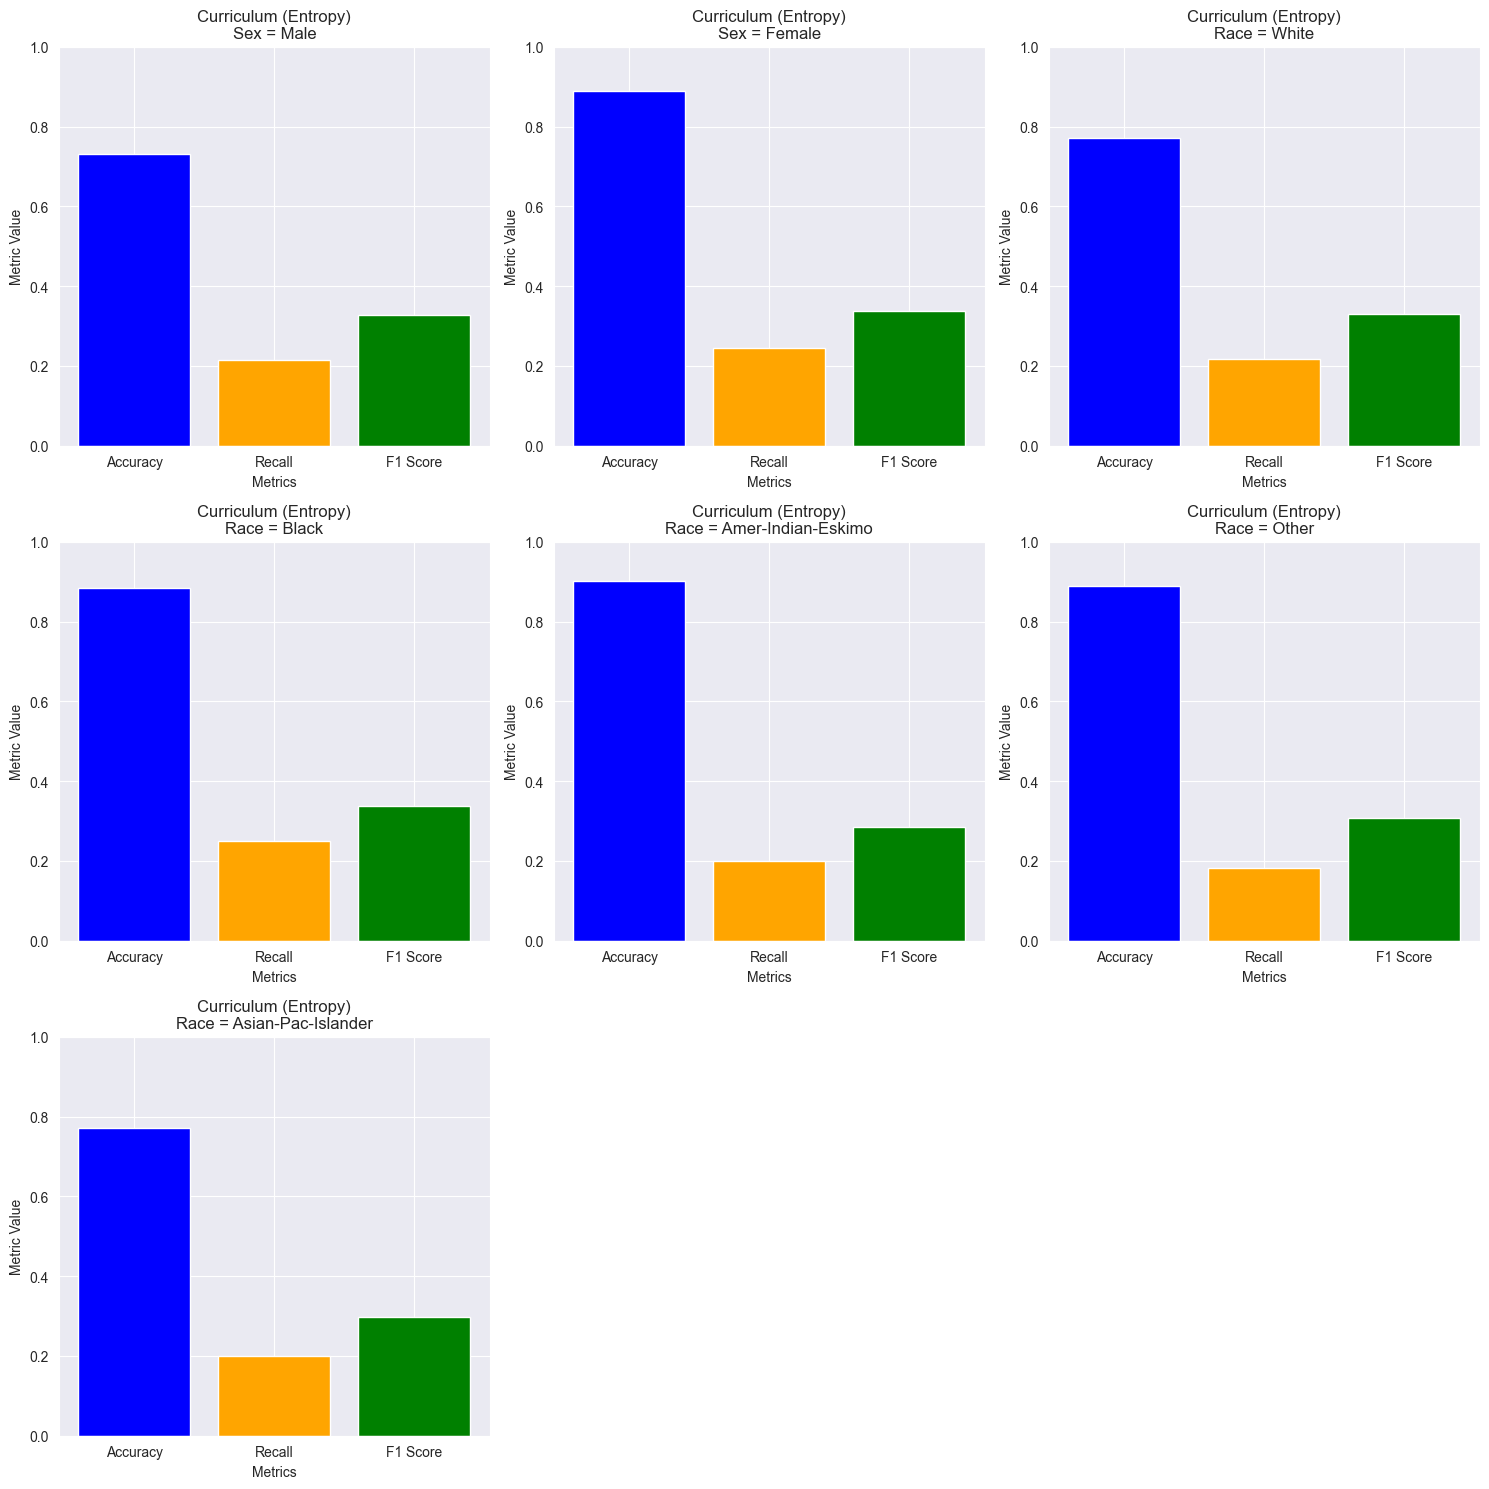

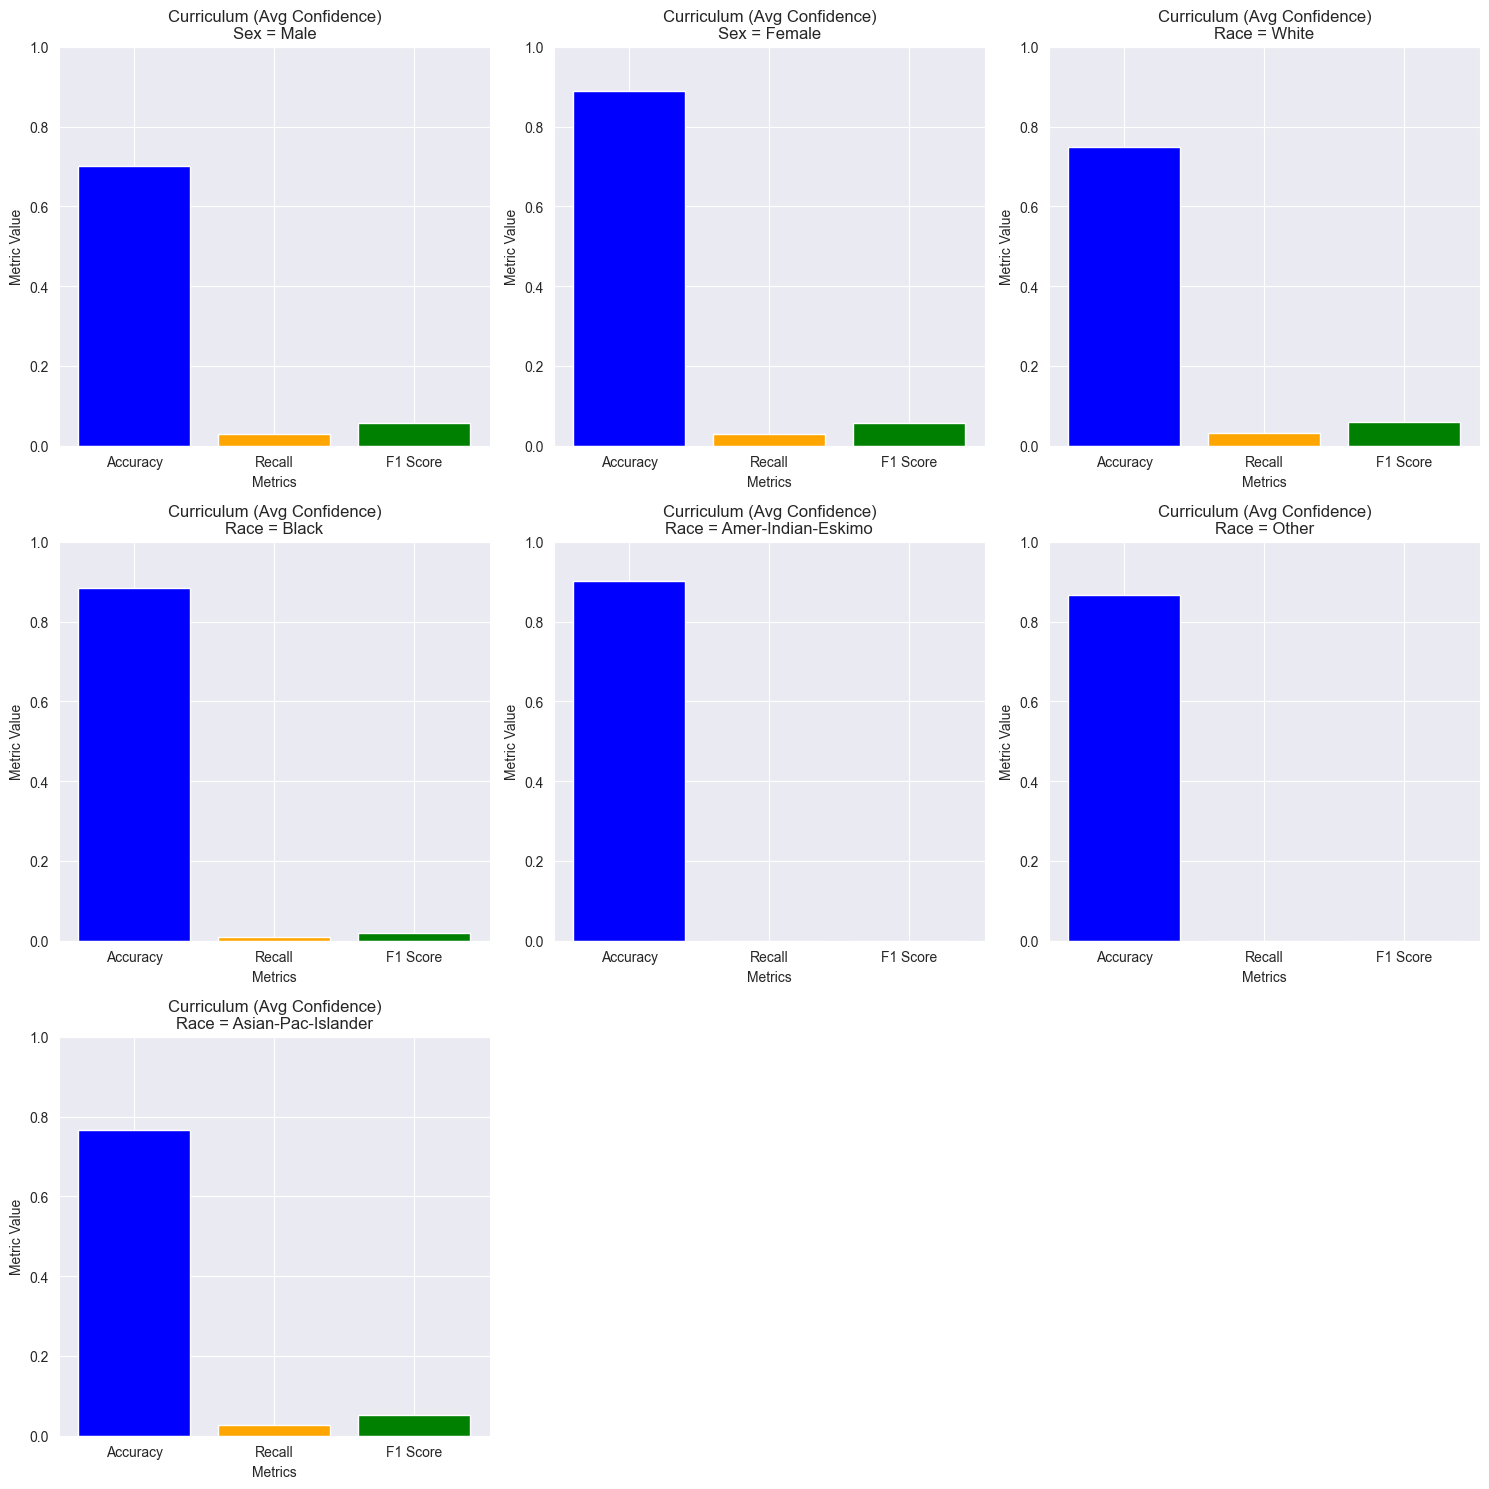

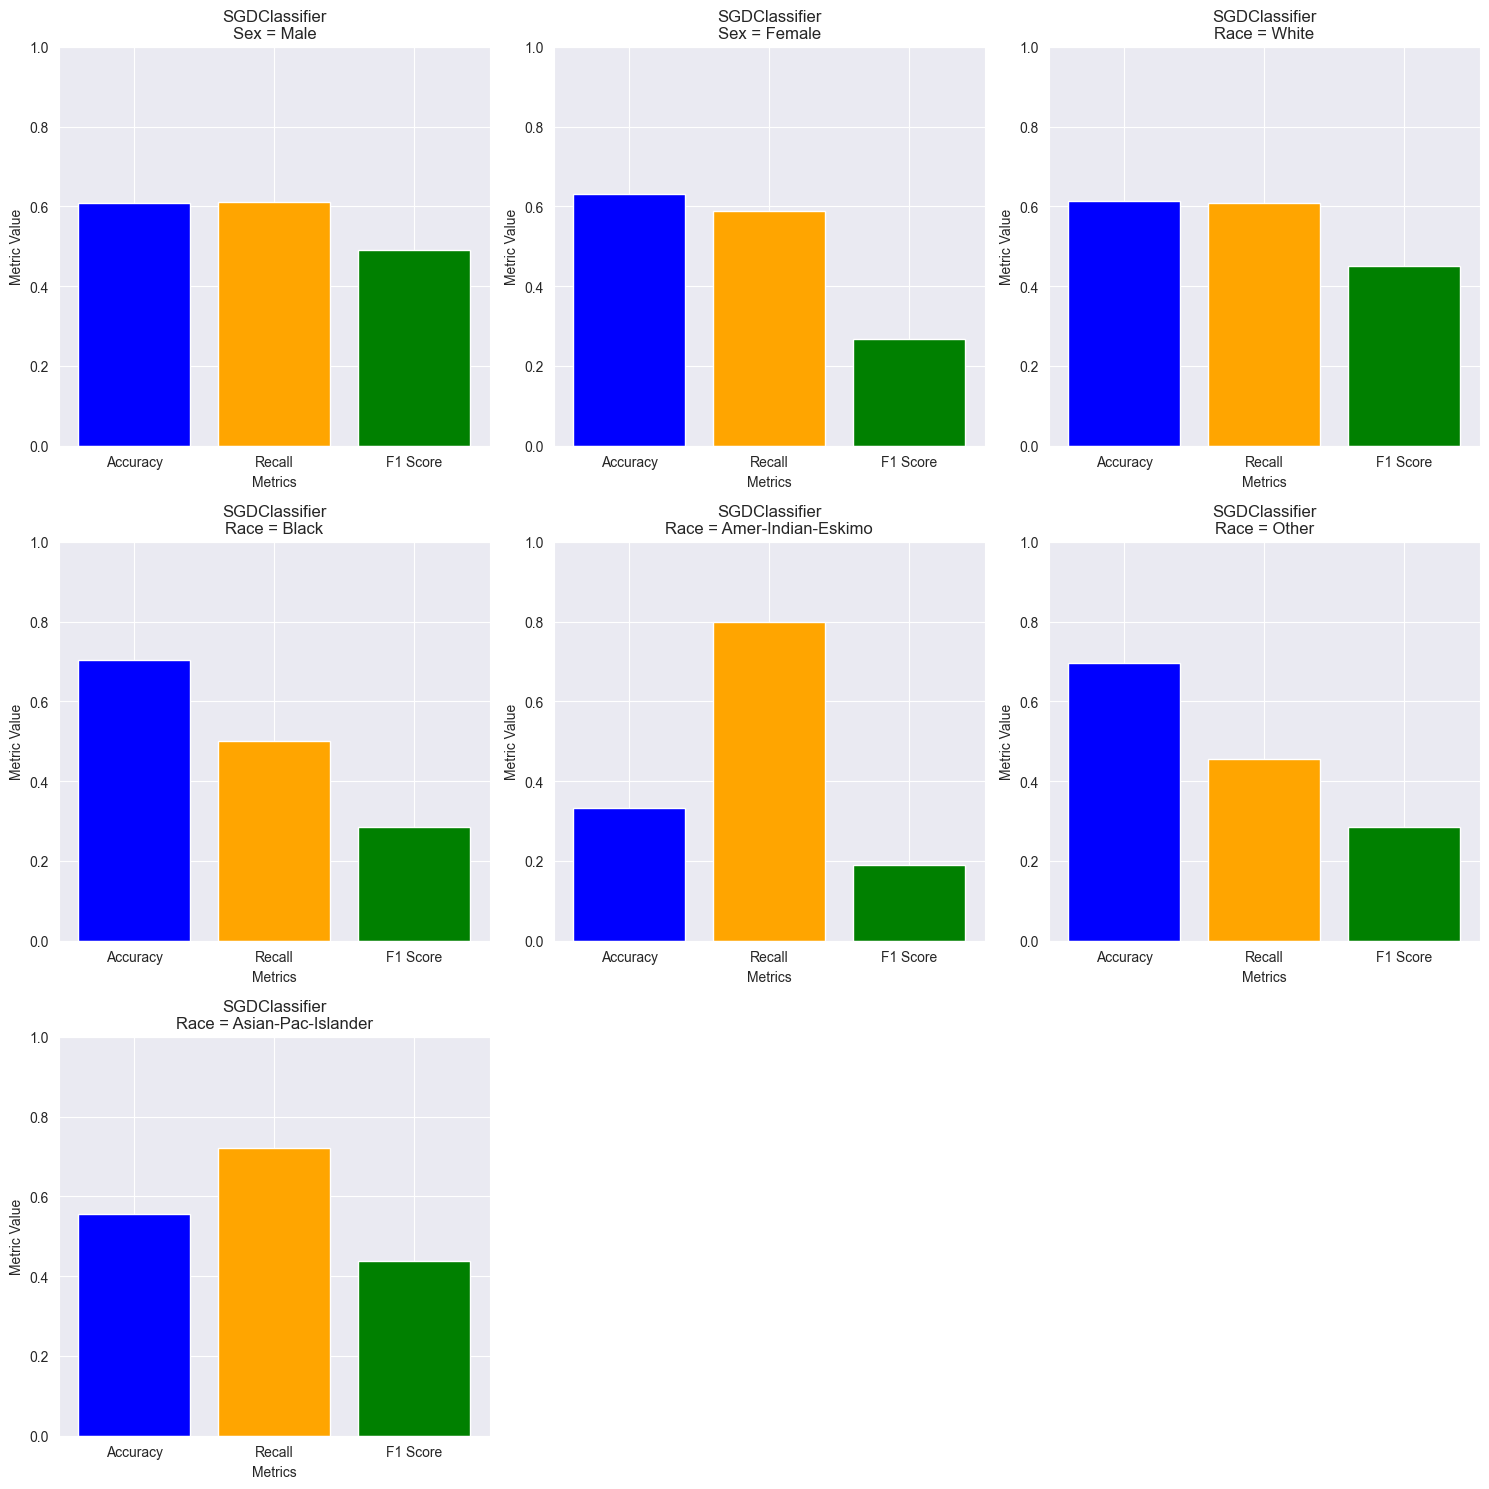

In [35]:
sensitive_features = {"sex": sensitive_test['sex'], "race": sensitive_test['race']}
sensitive_group_values = {key: feature.unique() for key, feature in sensitive_features.items()}

metrics = {
    "Accuracy": accuracy_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
}

model_predictions = {
    "Curriculum (Entropy)": y_pred_curriculum_ent_encoded,
    "Curriculum (Avg Confidence)": y_pred_curriculum_acc_encoded,
    "SGDClassifier": y_pred_sgd_encoded,
}

n_cols_per_row = 3

for model_name, y_pred in model_predictions.items():
    total_groups = sum(len(values) for values in sensitive_group_values.values())
    n_rows = (total_groups + n_cols_per_row - 1) // n_cols_per_row

    fig, axes = plt.subplots(n_rows, n_cols_per_row, figsize=(5 * n_cols_per_row, 5 * n_rows), squeeze=False)

    plot_index = 0

    for feature_name, feature_values in sensitive_group_values.items():
        for group in feature_values:
            mask = (sensitive_features[feature_name] == group)
            y_true_group = y_test_encoded[mask]
            y_pred_group = y_pred[mask]

            metric_values = [func(y_true_group, y_pred_group) for func in metrics.values()]
            metric_names = list(metrics.keys())

            row, col = divmod(plot_index, n_cols_per_row)
            ax = axes[row, col]

            ax.bar(metric_names, metric_values, color=["blue", "orange", "green"])
            ax.set_ylim(0, 1)
            ax.set_title(f"{model_name}\n{feature_name.capitalize()} = {group}")
            ax.set_ylabel("Metric Value")
            ax.set_xlabel("Metrics")

            plot_index += 1

    for i in range(plot_index, n_rows * n_cols_per_row):
        row, col = divmod(i, n_cols_per_row)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


### Explanation of Metrics by Sensitive Features for All Models

The bar plots above display **Accuracy**, **Recall**, and **F1 Score** for three models: **Curriculum Classifier (Entropy)**, **Curriculum Classifier (Avg Confidence)**, and **SGDClassifier**. Metrics are calculated for subgroups of sensitive features (`sex` and `race`) to assess the models' performance disparities.

---

### **Curriculum Classifier (Entropy)**

#### **Observations by `sex`**
- **Sex = Male**:
  - **High Accuracy**: The model predicts most samples correctly.
  - **Moderate Recall**: The model struggles to identify all positive samples.
  - **Moderate F1 Score**: Reflects the balance between precision and recall.
- **Sex = Female**:
  - **High Accuracy**: Similar to males, the model achieves high accuracy.
  - **Slightly Higher Recall**: Better identification of positive samples compared to males.
  - **F1 Score**: Comparable to males, indicating consistent performance.

#### **Observations by `race`**
- **Race = White**:
  - **High Accuracy**: Overall performance is strong for this group.
  - **Moderate Recall**: Positive cases are often missed.
  - **F1 Score**: Balanced but reflects the lower recall.
- **Race = Black**:
  - **Lower Recall**: Positive cases are frequently missed.
  - **F1 Score**: Slightly lower than for `White`, reflecting worse recall.
- **Race = Other Groups** (e.g., Amer-Indian-Eskimo, Asian-Pac-Islander):
  - **High Accuracy**: The model performs well on negative predictions.
  - **Low Recall**: Positive cases are often misclassified, particularly for smaller groups.
  - **F1 Score**: Declines due to poor recall, especially for smaller racial groups.

---

### **Curriculum Classifier (Avg Confidence)**

#### **Observations by `sex`**
- **Sex = Male and Female**:
  - **High Accuracy**: The model avoids false positives, leading to high accuracy.
  - **Extremely Low Recall**: Nearly all positive cases are missed due to a lack of positive predictions.
  - **F1 Score**: Severely impacted by poor recall, making the model unsuitable for identifying positive cases.

#### **Observations by `race`**
- **Race = White**:
  - **High Accuracy**: Very few false positives result in strong accuracy.
  - **Extremely Low Recall**: Positive cases are almost entirely missed.
  - **F1 Score**: Drastically reduced due to poor recall.
- **Race = Black**:
  - **Similar Issues**: High accuracy, but recall is almost zero.
  - **Smaller Groups** (e.g., Amer-Indian-Eskimo, Asian-Pac-Islander):
    - **High Accuracy**: Strong negative class predictions.
    - **Near Zero Recall and F1 Score**: The model fails to identify positive cases for smaller groups.

---

### **SGDClassifier**

#### **Observations by `sex`**
- **Sex = Male**:
  - **Moderate Accuracy**: Performance is more balanced compared to the curriculum models.
  - **Good Recall**: Better identification of positive cases, but at the cost of false positives.
  - **F1 Score**: Improved due to better recall compared to curriculum models.
- **Sex = Female**:
  - **Similar Trends**: Good recall but reduced precision due to more false positives.

#### **Observations by `race`**
- **Race = White**:
  - **Moderate Accuracy**: Lower than the curriculum models due to more false positives.
  - **Better Recall**: The model captures more positive cases than the curriculum classifiers.
  - **F1 Score**: Improved due to better recall.
- **Race = Black**:
  - **Balanced Performance**: Recall improves compared to curriculum models, but false positives are higher.
  - **Smaller Groups** (e.g., Amer-Indian-Eskimo, Asian-Pac-Islander):
    - **Better Recall**: Positive cases are identified more effectively compared to the curriculum models.
    - **Moderate F1 Score**: Balanced precision and recall despite the smaller group sizes.

---

### Key Takeaways
1. **Curriculum Classifier (Entropy)**:
   - Performs well for larger groups (`Male`, `White`), but recall issues persist for smaller groups.
   - High accuracy but recall and F1 score decline for underrepresented subgroups.

2. **Curriculum Classifier (Avg Confidence)**:
   - Focuses exclusively on avoiding false positives, leading to near-zero recall and F1 score for all groups.
   - Not effective for scenarios where positive class predictions are critical.

3. **SGDClassifier**:
   - Balances precision and recall better, resulting in improved F1 scores across most groups.
   - Recall is significantly better for smaller groups compared to the curriculum classifiers, making it a more equitable model.

4. **Fairness Implications**:
   - Both curriculum classifiers demonstrate performance disparities, particularly for smaller racial groups.
   - The SGDClassifier shows more consistent performance across sensitive groups, though precision issues (false positives) remain a concern.
